# Random Walks vs. Evolutionary Algorithms

One common misconception about evolutionary algorithms (EA) is that they're "just random walks."  In this notebook we show that EAs are *not* a random walk by first creating an actual random walk implementation, and then making one small, but significant, change to that random walk to transform it into a simple EA.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
import toolz
from leap_ec import Individual, context
from leap_ec import ops, util
from leap_ec.decoder import IdentityDecoder

from leap_ec.real_rep.problems import SpheroidProblem, plot_2d_problem
from leap_ec.real_rep.ops import mutate_gaussian
from leap_ec.real_rep.initializers import create_real_vector

from leap_ec.algorithm import generational_ea
from leap_ec.probe import CartesianPhenotypePlotProbe, BestSoFarProbe, FitnessPlotProbe

The spheroid function is a very simple and standard real-value optimization problem with a global minimum at (0,0) -- it's just a bowl, so it's all about a race to the bottom.  We show its 3D perspective and a 2D contour projection.

<IPython.core.display.Javascript object>


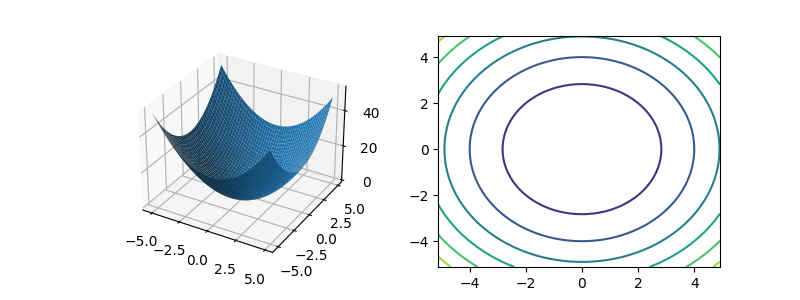

In [3]:
problem = SpheroidProblem()
bounds = problem.bounds

fig = plt.figure(figsize=(8, 3))

plt.subplot(121, projection='3d')
plot_2d_problem(problem, xlim=bounds, ylim=bounds, ax=plt.gca())

plt.subplot(122)
plot_2d_problem(problem, kind='contour', xlim=bounds, ylim=bounds, ax=plt.gca());

Next, we'll generate 10 random individuals that have two genes, one for the X coordinate and another for the Y.  We will then make a copy of each individual, in turn, and perturb each coordinate with some Gaussian noise, thus generating 10 entirely new individuals.  Then we'll replace the originals with the new ones, and repeat the process.

<IPython.core.display.Javascript object>


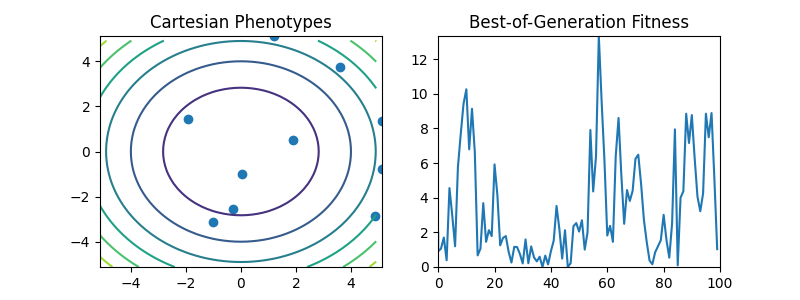

In [4]:
plt.figure(figsize=(8, 3))

plt.subplot(121)
trajectory_probe = CartesianPhenotypePlotProbe(contours=problem, ax=plt.gca(), xlim=bounds, ylim=bounds)

plt.subplot(122)
fitness_probe = FitnessPlotProbe(ax=plt.gca())

In [5]:
l=2
pop_size=10
generations=100

# create initial random population
parents = Individual.create_population(pop_size, 
                                            initialize=create_real_vector(bounds=[problem.bounds] * l),
                                            decoder=IdentityDecoder(), 
                                            problem=problem)

# evaluate initial population
parents = Individual.evaluate_population(parents)

# Set up a generation counter that records the current generation to core.context
generation_counter = util.inc_generation(context=context)

# Plot initial population
trajectory_probe(parents)
fitness_probe(parents)

while generation_counter.generation() < generations:
    offspring = toolz.pipe(parents,
                           ops.cyclic_selection, # deterministically select each parent, in turn
                           ops.clone, # copy them
                           mutate_gaussian(std=1,
                                           expected_num_mutations='isotropic',
                                           hard_bounds=problem.bounds), # perturb clone's coordinates
                           ops.evaluate, # now figure out its fitness
                           ops.pool(size=len(parents)), # collect desired number of new individuals
                           trajectory_probe,
                           fitness_probe)
    parents = offspring  # offspring become parents of next generation
    
    generation_counter() # increment to next generation
    
parents

[Individual([5.12, 1.3617484046004618], IdentityDecoder(), <leap_ec.real_rep.problems.SpheroidProblem object at 0x7f639ac10df0>),
 Individual([5.12, -0.7897594238870664], IdentityDecoder(), <leap_ec.real_rep.problems.SpheroidProblem object at 0x7f639ac10df0>),
 Individual([-1.015638709552654, -3.1114456868718623], IdentityDecoder(), <leap_ec.real_rep.problems.SpheroidProblem object at 0x7f639ac10df0>),
 Individual([3.5858866730673977, 3.735578622788023], IdentityDecoder(), <leap_ec.real_rep.problems.SpheroidProblem object at 0x7f639ac10df0>),
 Individual([0.03598476848958043, -1.0146854122806221], IdentityDecoder(), <leap_ec.real_rep.problems.SpheroidProblem object at 0x7f639ac10df0>),
 Individual([1.2144667795451043, 5.12], IdentityDecoder(), <leap_ec.real_rep.problems.SpheroidProblem object at 0x7f639ac10df0>),
 Individual([1.8982087285527558, 0.5093866432854841], IdentityDecoder(), <leap_ec.real_rep.problems.SpheroidProblem object at 0x7f639ac10df0>),
 Individual([-0.270074196130072

Each individual moves randomly in its neighborhood, as expected.

Now let's make _one_ small change to the above by adding a new operator.

<IPython.core.display.Javascript object>


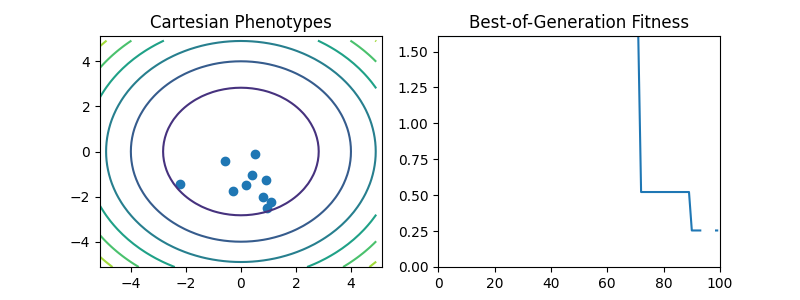

In [6]:
plt.figure(figsize=(8, 3))

plt.subplot(121)
new_trajectory_probe = CartesianPhenotypePlotProbe(contours=problem, ax=plt.gca(), xlim=bounds, ylim=bounds)

plt.subplot(122)
new_fitness_probe = FitnessPlotProbe(ax=plt.gca())

In [7]:
l=2
pop_size=10
generations=100

# create initial random population
parents = Individual.create_population(pop_size, 
                                            initialize=create_real_vector(bounds=[problem.bounds] * l),
                                            decoder=IdentityDecoder(), 
                                            problem=problem)

# evaluate initial population
parents = Individual.evaluate_population(parents)

# Set up a generation counter that records the current generation to core.context
generation_counter = util.inc_generation(context=context)

# Plot initial population
new_trajectory_probe(parents)
new_fitness_probe(parents)


while generation_counter.generation() < generations:
    offspring = toolz.pipe(parents,
                           ops.cyclic_selection,
                           ops.clone,
                           mutate_gaussian(std=1,
                                           expected_num_mutations='isotropic',
                                           hard_bounds=problem.bounds),
                           ops.evaluate,
                           ops.pool(size=len(parents)),
                           ops.insertion_selection(parents=parents), # <- ADDED THIS LINE
                           new_trajectory_probe,
                           new_fitness_probe)
    parents = offspring
    
    generation_counter() # increment to next generation
    
parents

[Individual([1.2018577667177648, -2.1835548998226764], IdentityDecoder(), <leap_ec.real_rep.problems.SpheroidProblem object at 0x7f639ac10df0>),
 Individual([0.49624266831537267, -0.08996576851434712], IdentityDecoder(), <leap_ec.real_rep.problems.SpheroidProblem object at 0x7f639ac10df0>),
 Individual([1.5486330551317888, -0.13275127651249496], IdentityDecoder(), <leap_ec.real_rep.problems.SpheroidProblem object at 0x7f639ac10df0>),
 Individual([0.8967279923986514, -1.241731117059461], IdentityDecoder(), <leap_ec.real_rep.problems.SpheroidProblem object at 0x7f639ac10df0>),
 Individual([-2.2136456033018055, -1.4504725085132089], IdentityDecoder(), <leap_ec.real_rep.problems.SpheroidProblem object at 0x7f639ac10df0>),
 Individual(array([-0.27544029, -1.7655237 ]), IdentityDecoder(), <leap_ec.real_rep.problems.SpheroidProblem object at 0x7f639ac10df0>),
 Individual([0.19261206458166968, -1.4877580993123587], IdentityDecoder(), <leap_ec.real_rep.problems.SpheroidProblem object at 0x7f639

So, by adding _selection_ we've turned a random walk into a very simple toy EA.  That is, in evolutionary algorithms _selection_ works in harmony with mutation (and optionally crossover) to have successive populations gradually settle on a solution.  In a sense, mutation allows for _exploration_, whereas selection does so for _exploitation_.